In [55]:
import urllib.request
import os
import pandas as pd
import numpy as np
import tarfile
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
## only run if haven't before! takes a while to generate .tar.gz files from URLs

# download the 56 zip files in Images_png in batches
# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading'+fn+'...')
    urllib.request.urlretrieve(link, fn)  # download the zip file

print("Download complete. Please check the checksums")

downloadingimages_01.tar.gz...
downloadingimages_02.tar.gz...
downloadingimages_03.tar.gz...
downloadingimages_04.tar.gz...
downloadingimages_05.tar.gz...
downloadingimages_06.tar.gz...
downloadingimages_07.tar.gz...
downloadingimages_08.tar.gz...
downloadingimages_09.tar.gz...
downloadingimages_10.tar.gz...
downloadingimages_11.tar.gz...
downloadingimages_12.tar.gz...
Download complete. Please check the checksums


# Image Extraction

In [11]:
def extract_tar_gz(tar_path, path_to_extract):
    # avoid duplicates -> check if the directory already exists
    dir_name = os.path.basename(tar_path).replace('.tar.gz', '')
    output_dir = os.path.join(path_to_extract, dir_name)

    # only extract images if that directory doesn't exist
    if not os.path.exists(output_dir):
        with tarfile.open(tar_path) as tar:
            tar.extractall(path=path_to_extract)
            print(f'Extracted {tar_path}')
    else:
        print(f'Skipped {tar_path}, already extracted')

# paths to .tar.gz files
tar_files = ['data/images_01.tar.gz', 'data/images_02.tar.gz',
             'data/images_03.tar.gz', 'data/images_04.tar.gz',
             'data/images_05.tar.gz', 'data/images_06.tar.gz',
             'data/images_07.tar.gz', 'data/images_08.tar.gz',
             'data/images_09.tar.gz', 'data/images_10.tar.gz',
             'data/images_11.tar.gz', 'data/images_12.tar.gz',]

# directory to store extracted images
extracted_images_dir = 'extracted_images/images'

# create create if doesn't exist
os.makedirs(extracted_images_dir, exist_ok=True)

# extract files from .tar.gz archives
for tar_file in tar_files:
    extract_tar_gz(tar_file, extracted_images_dir)

Extracted data/images_01.tar.gz
Extracted data/images_02.tar.gz
Extracted data/images_03.tar.gz
Extracted data/images_04.tar.gz
Extracted data/images_05.tar.gz
Extracted data/images_06.tar.gz
Extracted data/images_07.tar.gz
Extracted data/images_08.tar.gz
Extracted data/images_09.tar.gz
Extracted data/images_10.tar.gz
Extracted data/images_11.tar.gz
Extracted data/images_12.tar.gz


# Exploratory Data Analysis

In [34]:
# path to csv
metadata_path = 'Data_Entry_2017_v2020.csv'

# load metadata from csv
metadata = pd.read_csv(metadata_path)

In [43]:
# view metadata
metadata.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143


In [37]:
# check for missing labels in metadata
metadata['Finding Labels'].isna().sum()

0

In [49]:
# find unique label combinations
print(f"Number of unique label combinations: {len(metadata['Finding Labels'].unique())}\n")
print(metadata['Finding Labels'].unique())

Number of unique label combinations: 836

['Cardiomegaly' 'Cardiomegaly|Emphysema' 'Cardiomegaly|Effusion'
 'No Finding' 'Hernia' 'Hernia|Infiltration' 'Mass|Nodule' 'Infiltration'
 'Effusion|Infiltration' 'Nodule' 'Emphysema' 'Effusion' 'Atelectasis'
 'Effusion|Mass' 'Infiltration|Mass' 'Infiltration|Mass|Pneumothorax'
 'Mass' 'Cardiomegaly|Infiltration|Mass|Nodule'
 'Cardiomegaly|Effusion|Emphysema|Mass'
 'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax' 'Emphysema|Mass'
 'Emphysema|Mass|Pneumothorax' 'Pneumothorax' 'Emphysema|Pneumothorax'
 'Atelectasis|Pneumothorax' 'Cardiomegaly|Emphysema|Pneumothorax'
 'Mass|Pleural_Thickening' 'Cardiomegaly|Mass|Pleural_Thickening'
 'Pleural_Thickening' 'Effusion|Emphysema|Infiltration|Pneumothorax'
 'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax'
 'Effusion|Pneumonia|Pneumothorax' 'Effusion|Infiltration|Pneumothorax'
 'Effusion|Infiltration|Nodule' 'Atelectasis|Effusion|Pleural_Thickening'
 'Fibrosis|Infiltration' 'Fibrosis|Infilt

In [52]:
# split 'Finding Labels' into a list of labels for each image
metadata['Labels'] = metadata['Finding Labels'].apply(lambda x: x.split('|'))
metadata.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Labels
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,[Cardiomegaly]
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"[Cardiomegaly, Emphysema]"
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,"[Cardiomegaly, Effusion]"
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,[No Finding]
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,[Hernia]
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,[Hernia]
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,"[Hernia, Infiltration]"
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,[Hernia]
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,[Hernia]
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143,[Hernia]


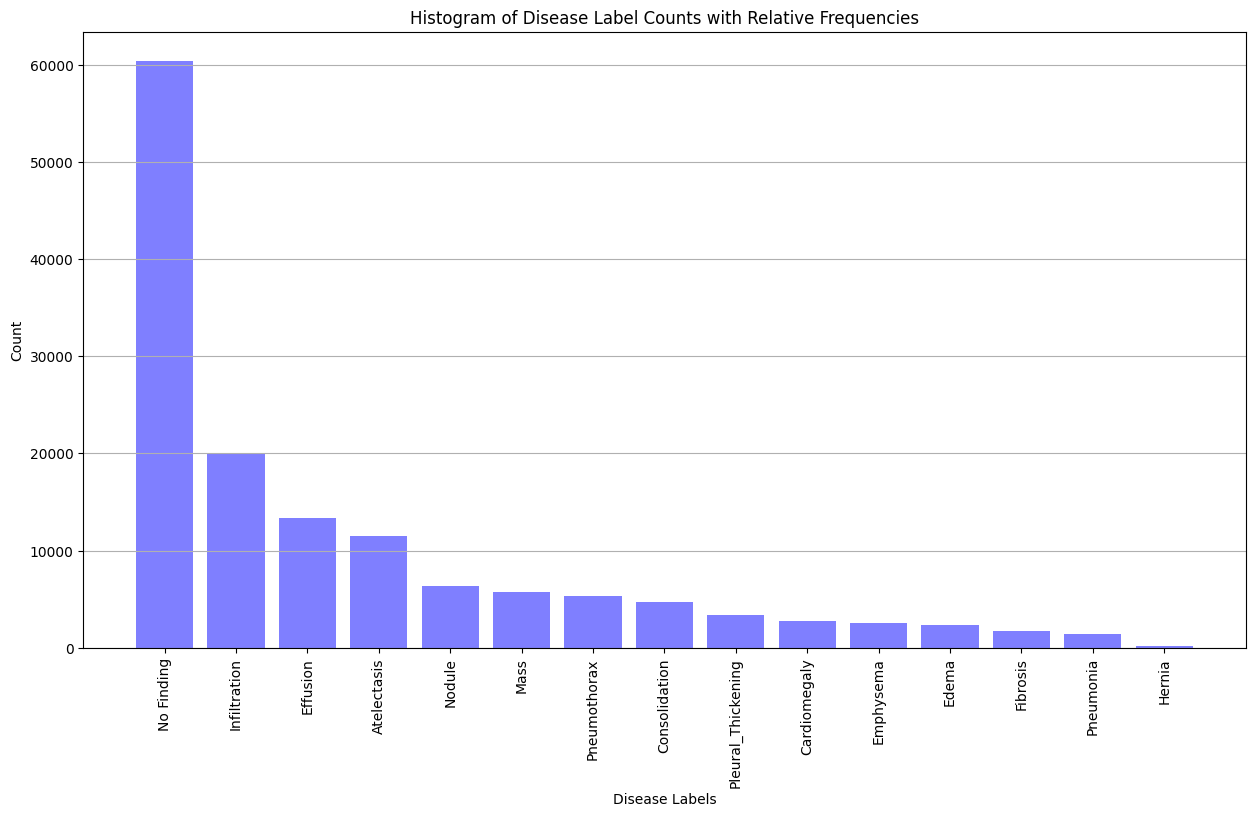

In [60]:
# flatten 'Labels' column into one single list of all labels
all_labels_flat_list = [label for labels_list in metadata['Labels'] for label in labels_list]

# count occurrences of each label
label_series = pd.Series(all_labels_flat_list)
label_counts = label_series.value_counts().sort_values(ascending=False)

# plot histogram of label counts
plt.figure(figsize=(15, 8))
bars = plt.bar(label_counts.index, label_counts.values, color='blue', alpha=0.5)

plt.xlabel('Disease Labels')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Histogram of Disease Label Counts with Relative Frequencies')
plt.grid(axis='y')

plt.show()

# Data Load and Prep

In [12]:
# 14 target disease categories
disease_categories = ['Atelectasis',
                      'Cardiomegaly',
                      'Effusion',
                      'Infiltration',
                      'Mass',
                      'Nodule',
                      'Pneumonia',
                      'Pneumothorax',
                      'Consolidation',
                      'Edema',
                      'Emphysema',
                      'Fibrosis',
                      'Pleural_Thickening',
                      'Hernia']

# transforms for image preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize the images
    transforms.ToTeånsor()])         # convert to PyTorch tensors

# make custom Dataset class for chest x-ray images
class ChestXRayDataset(Dataset):
    # constructor
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    # length method
    def __len__(self):
        return len(self.dataframe)

    # get item method
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        
        # create multi-label target vector
        label = np.zeros(len(disease_categories), dtype=float)
        for disease in self.dataframe.iloc[idx, 1].split('|'):
            if disease in disease_categories:
                label[disease_categories.index(disease)] = 1
        
        # apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, torch.from_numpy(label).float()

# create dataset and dataloaders
dataset = ChestXRayDataset(metadata, extracted_images_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define CNN Model

In [15]:
# see if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# function to get the accuracy for labels for each image
def multi_label_accuracy(outputs, labels):
    """
    Computes accuracy for multi-label classification. This makes sure that the number of
    predicted labels for an image matches the number of actual labels for that image
    """
    # sigmoid fxn converts outputs to probabilities
    probs = torch.sigmoid(outputs)
    accuracies = []
    
    for i in range(labels.size(0)):
        # count num of actual labels for the image
        num_labels = int(labels[i].sum())
        
        # get indices of the top 'num_labels' probs
        top_probs, top_preds = probs[i].topk(num_labels, largest=True)
        
        # create a prediction mask based on top probs indices
        pred_mask = torch.zeros_like(labels[i])
        pred_mask[top_preds] = 1
        
        # calculate accuracy for the image
        correct_preds = (pred_mask == labels[i]).float()
        accuracies.append(correct_preds.sum().item() / num_labels)
    
    # mean accuracy across the batch
    batch_accuracy = sum(accuracies) / len(accuracies)
    return batch_accuracy

# define simple CNN model
class SimpleCNN(nn.Module):
    # constructor
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, len(disease_categories))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    # forward method
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten tensors
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # no sigmoid function here
        return x

# initialize model, loss fxn, and optimizer
model = SimpleCNN().to(device)
criterion = nn.BCELoss()  # using binary cross-entropy loss since we have multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# fxn to calculate accuracy
def multi_label_accuracy(outputs, labels, threshold=0.5):
    outputs = (outputs > threshold).float()
    return torch.mean(((outputs == labels).float()).mean(dim=1)).item()

# Model Training and Validation

In [20]:
# num of training epochs
num_epochs = 10

# to track progress
print_interval = 1  # print every epoch
batch_print_interval = 100  # print every 100 batches

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    train_loss = 0.0
    train_accuracy = 0.0
    
    # iterate over data
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()   # zero the parameter gradients
        
        # forward pass and loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass and optimize
        loss.backward()
        optimizer.step()

        # calculate accuracy
        batch_acc = multi_label_accuracy(outputs, labels)
        
        # update running training loss and accuracy
        train_loss += loss.item() * images.size(0)
        train_accuracy += batch_acc
        
        # print progress for every 100 batches
        if (i + 1) % batch_print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, Batch Accuracy: {batch_acc:.4f}')

    # calculate avg loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    
    # validation loop
    model.eval()  # 'eval' mode
    val_loss = 0.0
    val_accuracy = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # calculate accuracy
            batch_acc = multi_label_accuracy(outputs, labels)
            
            # update running val loss and accuracy
            val_loss += loss.item() * images.size(0)
            val_accuracy += batch_acc
    
    # calculate avg loss and accuracy
    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    
    # print training and validation stats
    if (epoch + 1) % print_interval == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

Epoch: 1/10, Batch: 100/2803, Batch Loss: 0.1817, Batch Accuracy: 0.9531
Epoch: 1/10, Batch: 200/2803, Batch Loss: 0.2238, Batch Accuracy: 0.9330
Epoch: 1/10, Batch: 300/2803, Batch Loss: 0.2192, Batch Accuracy: 0.9375
Epoch: 1/10, Batch: 400/2803, Batch Loss: 0.2040, Batch Accuracy: 0.9353
Epoch: 1/10, Batch: 500/2803, Batch Loss: 0.1812, Batch Accuracy: 0.9442
Epoch: 1/10, Batch: 600/2803, Batch Loss: 0.2006, Batch Accuracy: 0.9397
Epoch: 1/10, Batch: 700/2803, Batch Loss: 0.2306, Batch Accuracy: 0.9330
Epoch: 1/10, Batch: 800/2803, Batch Loss: 0.1773, Batch Accuracy: 0.9464
Epoch: 1/10, Batch: 900/2803, Batch Loss: 0.1232, Batch Accuracy: 0.9665
Epoch: 1/10, Batch: 1000/2803, Batch Loss: 0.1598, Batch Accuracy: 0.9554
Epoch: 1/10, Batch: 1100/2803, Batch Loss: 0.1670, Batch Accuracy: 0.9554
Epoch: 1/10, Batch: 1200/2803, Batch Loss: 0.2237, Batch Accuracy: 0.9330
Epoch: 1/10, Batch: 1300/2803, Batch Loss: 0.1611, Batch Accuracy: 0.9554
Epoch: 1/10, Batch: 1400/2803, Batch Loss: 0.20

# Save the Model

In [22]:
# save the trained model to a file
model_save_path = 'data/chest_xray_model.pth'
torch.save(model.state_dict(), model_save_path)

print("Model saved to {}".format(model_save_path))

Model saved to data/chest_xray_model.pth


# Analysis Preparation

In [24]:
# load model (saves time)
model.load_state_dict(torch.load(model_save_path))

model.eval()  # set model to eval mode
val_loss = 0.0
val_accuracy = 0.0

# initialize lists
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # append true labels to true_labels list and output predictions to predicted_labels list
        true_labels.append(labels.cpu().numpy())
        # saw the threshold online, going to change in next iteration but want to see what this yields first
        predicted = max(torch.sigmoid(outputs).cpu().numpy())  # threshold to obtain binary predictions
        predicted_labels.append(predicted)

# convert lists to np arrays
true_labels_array = np.vstack(true_labels)
pred_labels_array = np.vstack(predicted_labels)

In [29]:
true_labels

[array([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

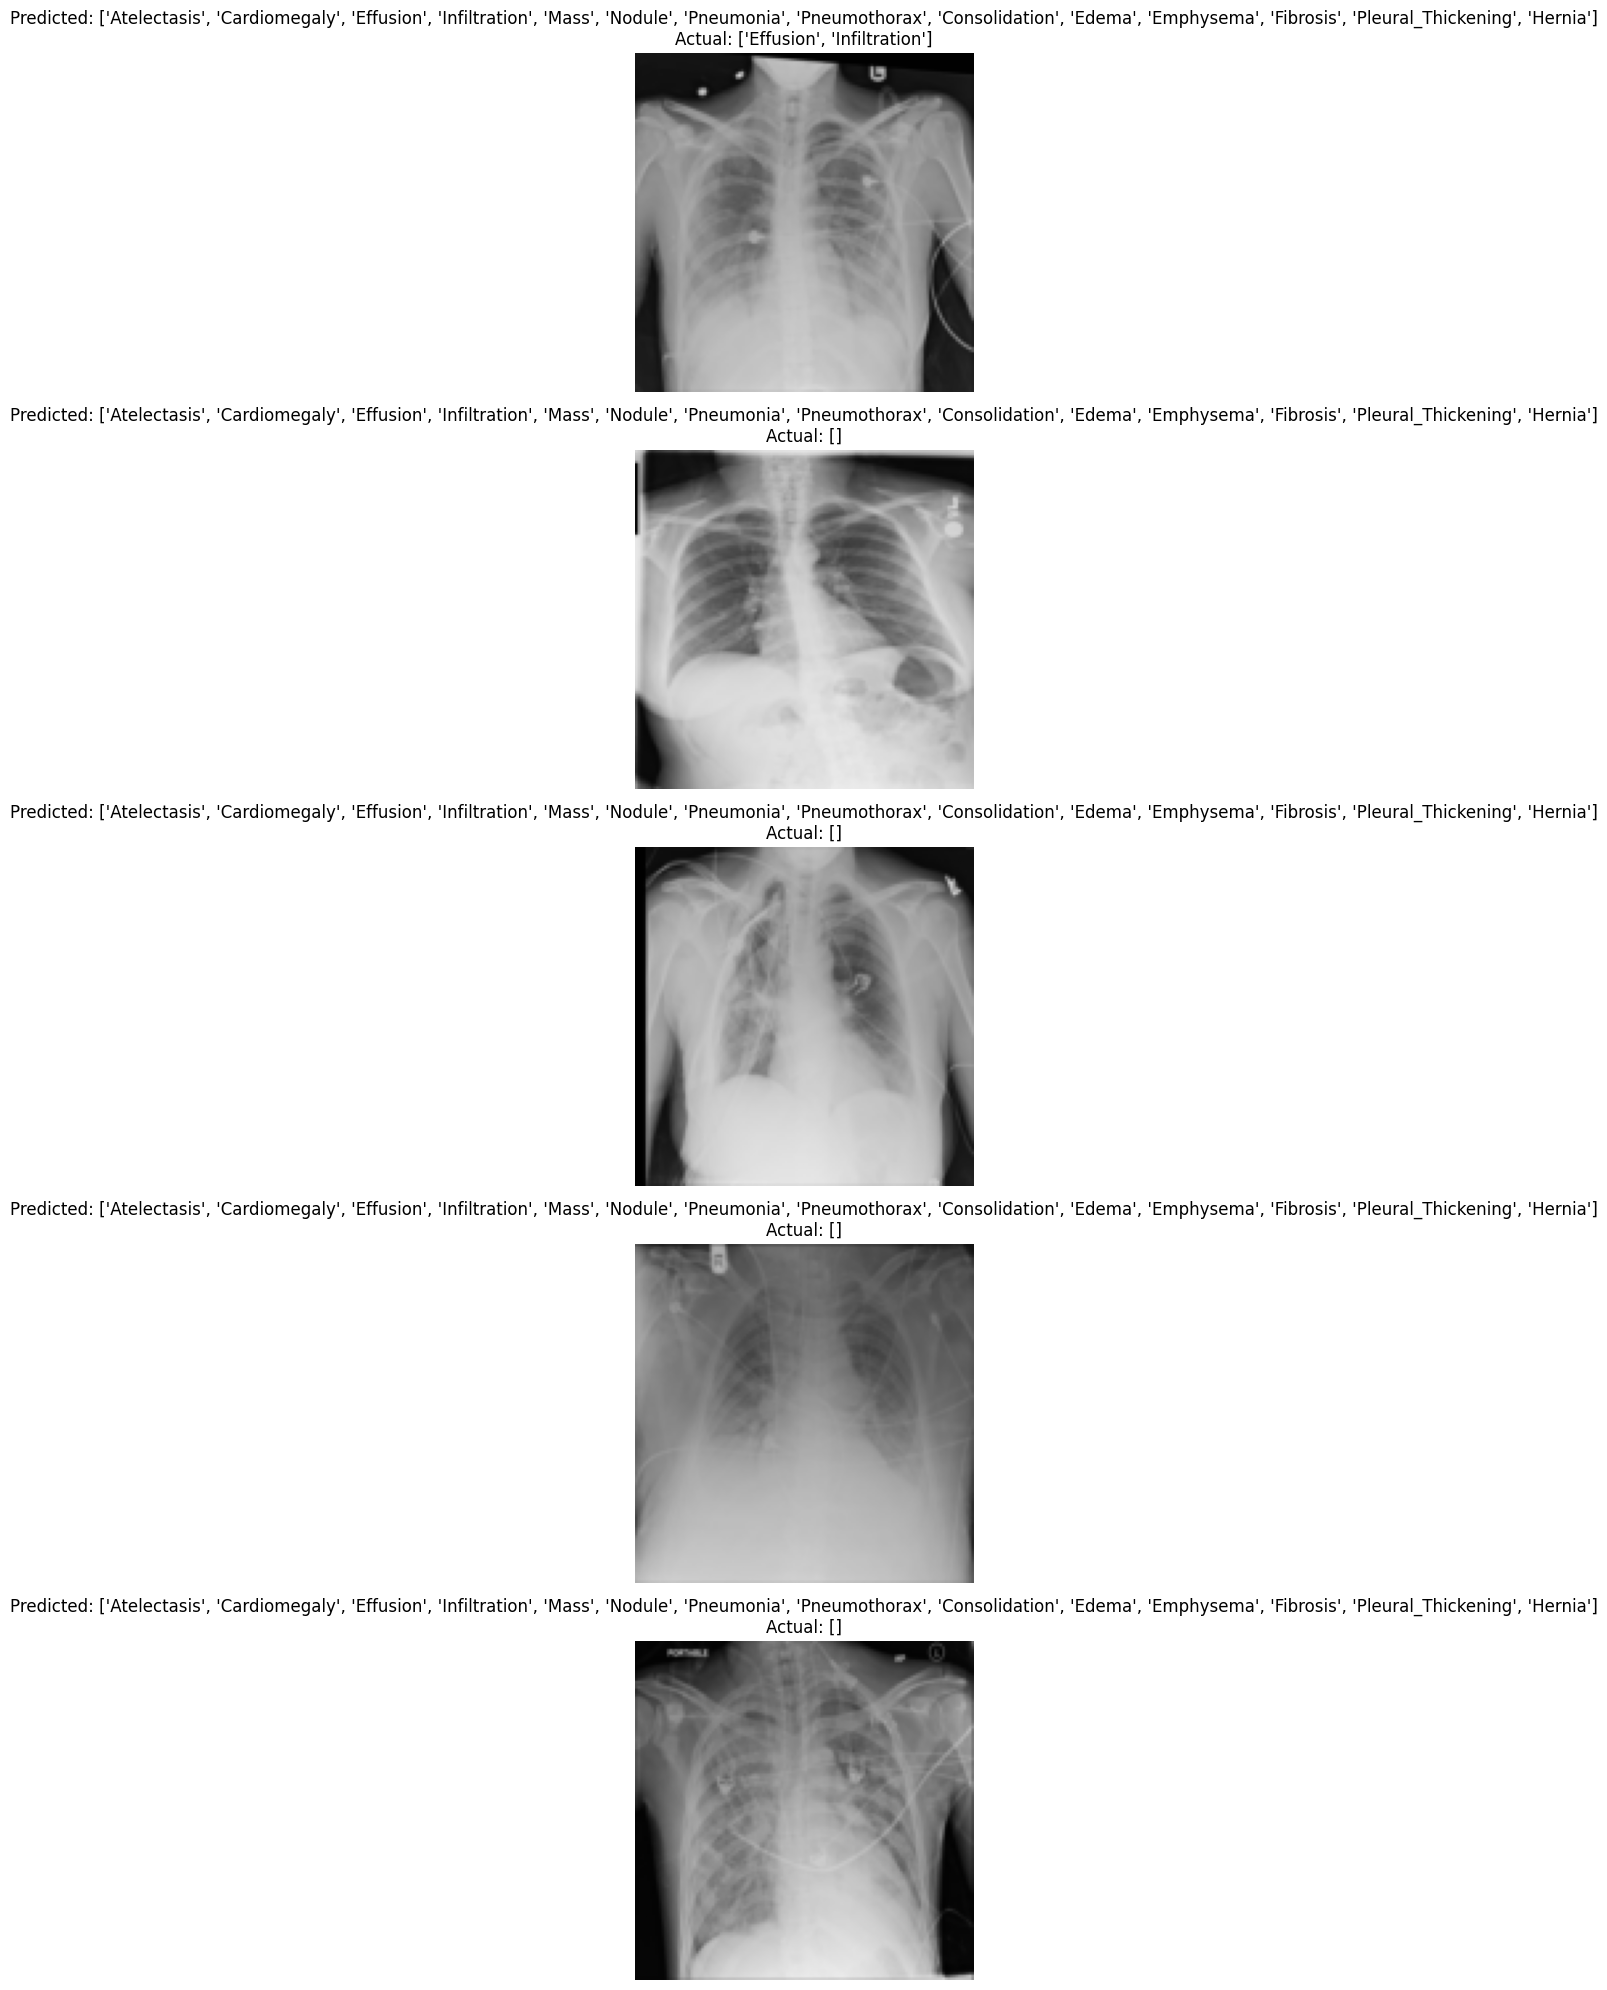

In [31]:
import matplotlib.pyplot as plt

# Get the first 5 images and labels from the validation set
images, labels = next(iter(val_loader))
images, labels = images[:5], labels[:5]

# Get predictions for the first 5 images
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    outputs = model(images.to(device))
    predictions = torch.sigmoid(outputs).cpu() > 0.5

# Convert labels and predictions to numpy arrays for easier manipulation
labels = labels.cpu().numpy()
predictions = predictions.cpu().numpy()

# Define the disease categories for labeling purposes
disease_categories = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

# Plot the images with their predicted and actual labels
fig, axes = plt.subplots(5, 1, figsize=(5, 20))  # 5 rows, 1 column
for i in range(5):
    ax = axes[i]
    ax.imshow(images[i].permute(1, 2, 0))  # Convert the tensor image to a format suitable for matplotlib
    ax.axis('off')
    predicted_labels = [disease_categories[j] for j in range(len(predictions[i])) if predictions[i][j]]
    actual_labels = [disease_categories[j] for j in range(len(labels[i])) if labels[i][j]]
    ax.set_title(f'Predicted: {predicted_labels}\nActual: {actual_labels}')

plt.tight_layout()
plt.show()
